<center>
    <img src="./assets/molssi_ai.png"
         alt="MolSSI-AI Logo"
         width=400 
         height=250
    />
</center>

## Learning Objectives
- Learn the basics of linear regression in the context of a practical cheminformatics problem
- Become familiar with the exploratory data analysis (EDA) process and data featurization
- Understand the concept of model evaluation and the importance of cross-validation
- Build and evaluate a variety of machine learning models with `scikit-learn`

Before we start, let's make sure we have the necessary libraries ready for use

In [1]:
import pandas as pd                 # for data manipulation
import seaborn as sns               # for data visualization
import matplotlib.pyplot as plt     # for data visualization
import numpy as np                  # for numerical operations

from sklearn.linear_model import LinearRegression           # for creating a linear regression model
from sklearn.dummy import DummyRegressor                    # for creating a base regressor to compare the model with
from sklearn.model_selection import train_test_split        # for splitting the data into training and testing sets
from sklearn.metrics import mean_squared_error, r2_score    # for evaluating the model
from sklearn.preprocessing import StandardScaler            # for scaling the data

<div class="alert alert-block alert-info">
    <b>Note</b>
    <br>
    <br>
    We have added comments to clarify the purpose of each imported library.
</div>

## Problem Statement

In this tutorial, we will be working on a **supervised learning** problem which involves both the featurized data and their corresponding labels. The goal is to predict the solubility of a molecule given its chemical structure using regression models. The dataset we will be using is the **Delaney's solubility dataset**. It contains the chemical structures of 1144 compounds along with their experimentally measured solubility in mol/L. We provide the preprocessed dataset in the [repository](https://github.com/MolSSI-Education/bcce-2024/tree/main/data) comma-separated value (CSV) format.

Let's read the solubility data and take a look at a few samples in the dataset

In [2]:
# Path to the preprocessed data file
data_path = "./data/solubility-processed.csv"

# Read the data into a DataFrame
df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
df.head()

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.5954,167.850,0.0,0.0,-2.18
1,2.3765,133.405,0.0,0.0,-2.00
2,2.5938,167.850,1.0,0.0,-1.74
3,2.0289,133.405,1.0,0.0,-1.48
4,2.9189,187.375,1.0,0.0,-3.04


The dataset contains the following columns:
- **MolLogP**: solubility values estimated by [Daylight CLOGP version 4.72](https://www.daylight.com/dayhtml/doc/clogp/index.html)
- **MolWt**: molecular weight
- **NumRotatableBonds**: number of rotatable bonds
- **AromaticProportion**: the portion of heavy atoms that are in an aromatic ring
- **logS**: the solubility of the molecule in mol/L measured at 25 $\degree C$ 

### Sidebar: A Brief Note on Solubility

The solubility of a molecule is a critical property in medicinal chemistry, drug discovery, agrochemistry as it determines the bioavailability of a drug.
The **Partition coefficient** measures the propensity of a neutral compound to dissolve in a mixture of two immiscible solvents, often water and octanol. In simple terms, it determines how much of a solute dissolves in the water phase versus the organic portion.

The partition coefficient, $P$, is defined as:

$$
P = \frac{[Solute]_{\text{organic}}}{[Solute]_{\text{aqueous}}}     
$$

where $[Solute]_{\text{organic}}$ and $[Solute]_{\text{aqueous}}$ are the concentrations of the solute in the organic and aqueous phases, respectively.
Instead of $P$, we often use the logarithm of the partition coefficient, $\log P$, which is more convenient to work with. A negative value of $\log P$ indicates that the solute is more soluble in water, while a positive value indicates that the solute is more soluble in the organic phase. When $\log P$ is close to zero, the solute is equally soluble in both phases. Although $\log P$ is a constant value, its magnitude is dependent on the measurement conditions and the choice of the organic solvent.

<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    <br>
    <br>
    What does logP value of 1 mean?
</div>

#### Solution

A $\log P$ value of 1 indicates that the solute is 10 times more soluble in the organic phase than in the aqueous phase.

## Exploratory Data Analysis (EDA)

The first step after defining the problem and accessing the data is to perform exploratory data analysis (EDA). EDA is a crucial step in the data analysis process as it helps us understand the data, identify patterns, and detect anomalies. It involves summarizing the main characteristics of the data, often using visual methods. 

Loading the data into a pandas DataFrame provides a convenient way to perform EDA. Let's start by getting a high-level overview of the dataset
using the ``info`` function

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MolLogP             1144 non-null   float64
 1   MolWt               1144 non-null   float64
 2   NumRotatableBonds   1144 non-null   float64
 3   AromaticProportion  1144 non-null   float64
 4   logS                1144 non-null   float64
dtypes: float64(5)
memory usage: 44.8 KB


Since the data is already preprocessed, the ``Non-Null Count`` for all feature columns should be equal to the total number of samples in the dataset, *i.e.,* 1144. All features are of numerical type ``float64``. The experimentally measured solubility in the last column ``logS`` is the target variable that we want to our model to be able to predict using the remaining properties as features.

The ``describe`` function provides a statistical summary of all numerical features in our dataset. The statistics provide the count, mean, standard deviation, minimum, 25th percentile, median, 75th percentile, and maximum values for each feature.

In [4]:
df.describe()

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,2.449133,204.631675,2.173951,0.364932,-3.057997
std,1.866003,102.620500,2.627398,0.343305,2.096502
min,-7.571400,16.043000,0.000000,0.000000,-11.600000
25%,1.414900,122.126000,0.000000,0.000000,-4.332250
50%,2.340300,183.594500,1.000000,0.375000,-2.870500
75%,3.406475,270.715750,3.000000,0.666667,-1.600000
max,10.388600,780.949000,23.000000,1.000000,1.580000


This information is extremely useful for understanding the data and the distribution of the features. It helps in identifying any missing values or anomalies in the data or if our data requires any preprocessing. For example, the skeweness of the data which is measured by comparing the mean and median values can be visualized using Pandas's ``hist`` function

array([[<Axes: title={'center': 'MolLogP'}>,
        <Axes: title={'center': 'MolWt'}>],
       [<Axes: title={'center': 'NumRotatableBonds'}>,
        <Axes: title={'center': 'AromaticProportion'}>],
       [<Axes: title={'center': 'logS'}>, <Axes: >]], dtype=object)

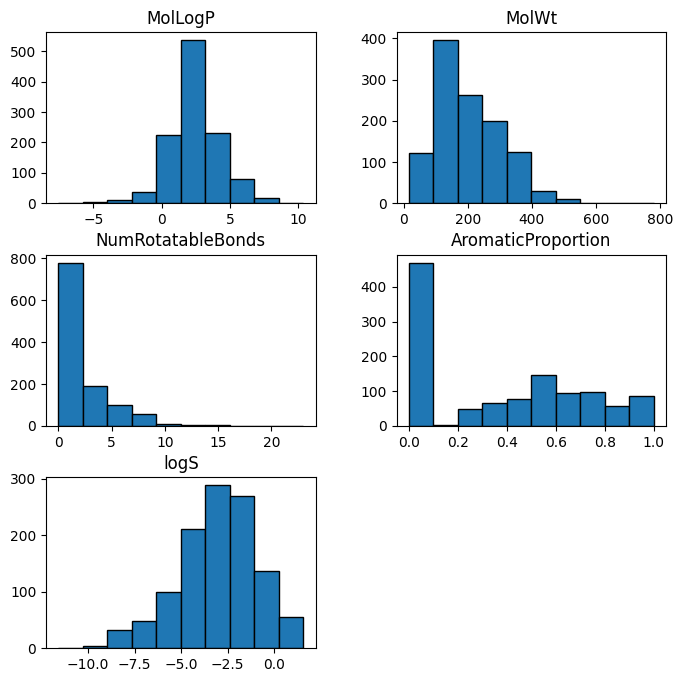

In [5]:
df.hist(figsize=(8,8), edgecolor='black', grid=False)

Clearly, the solubility values are normally distributed while other features are more or less positively or negatively skewed. The Pandas library helps us quantify these observations for each feature using the ``skew`` function.

In [6]:
df.skew()

MolLogP              -0.012982
MolWt                 0.890477
NumRotatableBonds     2.158178
AromaticProportion    0.226302
logS                 -0.484590
dtype: float64

The numerical values of skewness can be interpreted as follows:
- The skewness value of zero indicates a perfect symmetrical distribution,
- a skewness between -0.5 and 0.5 indicates an approximately symmetric distribution,
- a skewness between -1 and -0.5 (or 0.5 and 1) indicates a moderately skewed distribution,
- a skewness between -1.5 and -1 (or 1 and 1.5) indicates a highly skewed distribution, and
- a skewness less than -1.5 (or greater than 1.5) indicates an extremely skewed distribution.

## Feature Engineering

Once we have a good understanding of the data, we can move on to the next step, which is feature engineering. Feature engineering is the process of transforming raw data into a format that is suitable for machine learning models. It involves creating new features, selecting relevant features, and transforming existing features to improve the model's performance.

Here, we use Pandas's ``corr`` function to calculate the correlation matrix between the features and the target variable. The correlation matrix provides insights into the relationships between the features and the target variable. A correlation value close to 1 indicates a strong positive relationship, while a correlation value close to -1 indicates a strong negative relationship. A correlation value close to 0 indicates no relationship between the features.

In [7]:
df.corr(method='pearson')

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
MolLogP,1.000000,0.468097,0.205607,0.250977,-0.827959
MolWt,0.468097,1.000000,0.394219,0.098855,-0.637324
NumRotatableBonds,0.205607,0.394219,1.000000,-0.296737,-0.238508
AromaticProportion,0.250977,0.098855,-0.296737,1.000000,-0.268108
logS,-0.827959,-0.637324,-0.238508,-0.268108,1.000000


It maybe eaiser to see the relationship between the features and the target variable using a heatmap correlation matrix plot. We can use the Seaborn library to create a heatmap plot of the correlation matrix

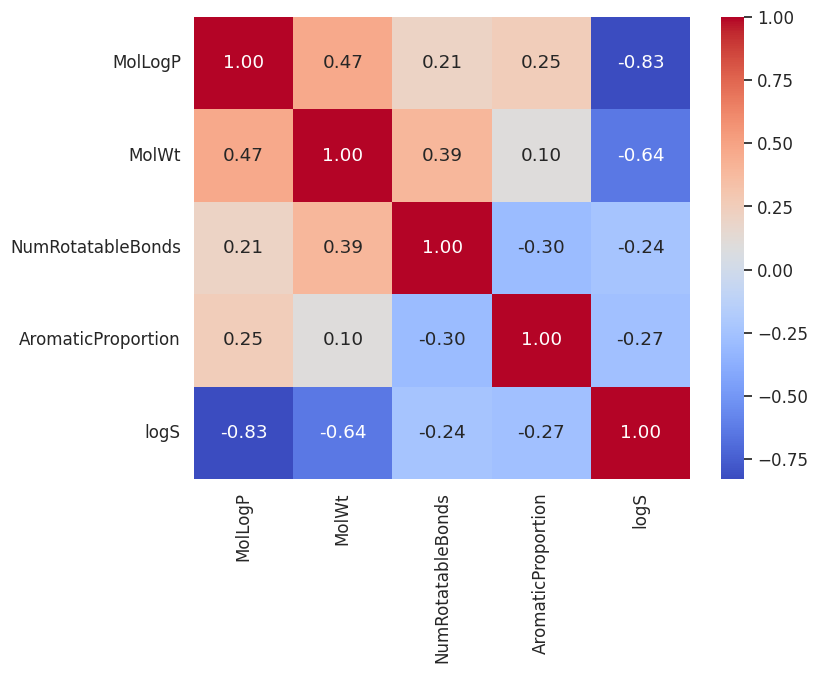

In [8]:
# Create a plot object
plt.figure(figsize=(8,6))

# Calculate the correlation matrix
corr = df.corr()

# Create a heatmap
sns.set(font_scale=1.1)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

# Display the heatmap
plt.show()

Our coloring scheme makes it easy to uncover the relationships between the features. The darker the color, the stronger the correlation. The diagonal line represents the correlation of each feature with itself, which is always 1. The red color indicates a positive correlation, while the blue color indicates a negative correlation.

From the correlation matrix, we can see that ``MolLogP`` shows a strong negative correlation with the target variable ``logS``. This is expected as the CLOGP model estimates the solubility of a molecule from its chemical structure. The remaining features, ``MolWt``, ``AromaticProportion``, and ``NumRotatableBonds``show weaker correlations with the target variable, respectively.

The next step in the feature engineering process is to split the data into features and target variables. We will use the ``train_test_split`` function from the ``sklearn.model_selection`` module to split the data into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance.

In [9]:
# Create the feature matrix (X), feature vector (x), and the target vector (y)
X = df.drop(columns=['logS'])
x = X["MolLogP"]
y = df['logS']

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

# Reshape the data into 2D arrays of shape (n_samples, 1)
x_train = x_train.values.reshape(-1,1)
x_test = x_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

# Display the shapes of the training and testing sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((915, 1), (229, 1), (915, 1), (229, 1))

After splitting our data, we need to scale our training (and test) features. Scaling is a crucial step in the data preprocessing pipeline as it ensures that all features have the same scale as many machine learning models are sensitive to the scale of the input features. We will use the ``StandardScaler`` from the ``sklearn.preprocessing`` module to scale our features.

In [10]:
# Create the standard scaler object
scaler = StandardScaler()

# Fit and transform the training feature vector x_train
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test feature vector x_test
x_test_scaled = scaler.transform(x_test)

# Make sure the training data is scaled correctly
print(f" Training feature mean: {x_train_scaled.mean():.5f}")
print(f" Training feature standard deviation: {x_train_scaled.std():.5f}\n")

# Print the scaler statistics on the test data
print(f" Testing feature mean: {x_test_scaled.mean():.5f}")
print(f" Testing feature standard deviation: {x_test_scaled.std():.5f}")

 Training feature mean: -0.00000
 Training feature standard deviation: 1.00000

 Testing feature mean: -0.02540
 Testing feature standard deviation: 1.07506


## Building and Training a Linear Regression Model

### Baseline Model

The next step after the data preparation is to build and train our linear regression model. First we will build a simple linear regression model which focuses on the relationship between a single feature (``MolLogP``) and the target variable (``logS``). 

In order to be able to compare the performance of our models, we create a baseline model using the ``DummyRegressor`` class from the ``sklearn.dummy`` module. This class provides a simple way to create a model that predicts the mean value of the target variable.

In [11]:
# Create a baseline model using the mean value of the target variable
base_model = DummyRegressor(strategy="mean")

# Fit the model to the training data
base_model.fit(x_train_scaled, y_train)

# Make predictions on the testing data
y_pred_base = base_model.predict(x_test_scaled)

# Calculate the performance metrics and store them in a DataFrame
results = pd.DataFrame({
    "Coefficients": [np.array(base_model.constant_)],         # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_base),     # the mean squared error
    "R2": r2_score(y_test, y_pred_base)                 # the coefficient of determination
}, index=["Baseline"])
                            

# Set the formatting style
results.style.format(
    {
        "MSE": "{:.3f}",
        "R2": "{:.2f}"
    }
)

,Coefficients,MSE,R2
Baseline,[[-3.07538251]],4.586,-0.00


### Linear Regression Model

Now, let's build and train our single-feature linear regression model. We will use the ``LinearRegression`` class from the ``sklearn.linear_model`` module to create the model. The ``fit`` method is used to train the model on the training data. Once the model is trained, we can use the ``predict`` method to make predictions on the test data.

In [12]:
# Create a simple linear regression model
simple_reg_model = LinearRegression()

# Fit the model to the training data
simple_reg_model.fit(x_train_scaled, y_train)

# Make predictions on the test data
y_pred_simple = simple_reg_model.predict(x_test_scaled)

# Calculate the performance metrics
simple_model_results = pd.DataFrame({
    "Coefficients": [np.array(simple_reg_model.coef_)],    # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_simple),     # the mean squared error
    "R2": r2_score(y_test, y_pred_simple)                 # the coefficient of determination
}, index=["Simple-Linear-Regression"])

# Store the results into results DataFrame
results = pd.concat([results, simple_model_results])
results

,Coefficients,MSE,R2
Baseline,[[-3.0753825136612023]],4.586189,-0.001647
Simple-Linear-Regression,[[-1.731915805006306]],1.533885,0.664992


From the table above, we can see our simple linear regression model using the ``MolLogP`` feature has a mean squared error (MSE) of 1.05 and a coefficient of determination ($R^2$) of 0.66. We can visualize the performance of our fitted models using ``matplotlib`` as shown below

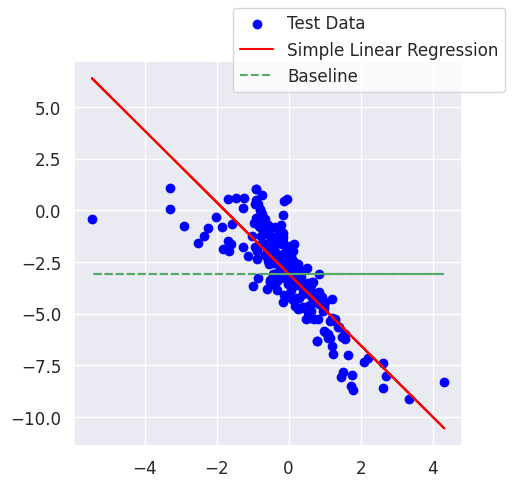

In [13]:
# Create a plot object
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the test data
ax.scatter(x_test_scaled, y_test, color='blue', label='Test Data')

# Plot the simple linear regression model
ax.plot(x_test_scaled, y_pred_simple, color='red', label='Simple Linear Regression')

# Plot the baseline model
ax.plot(x_test_scaled, y_pred_base, "g--", label="Baseline")

# Create the legends
fig.legend(facecolor='white')

# Show the plot
plt.show()

### Multiple Linear Regression Model

Using the ``MolLogP`` feature with highest correlation with the target variable ``logS`` is a good starting point. The reason is that we knew beforehand that the CLOGP estimations would be a great predictor of solubility. However, we can improve our model by including other features that show some correlation with the target variable. This is where multiple linear regression comes in.

We will build a multiple linear regression model using all the features in our dataset and the process is similar to building a single-feature linear regression model. The ``fit`` method is used to train the model on the training data, and the ``predict`` method is used to make predictions on the test data.

In [14]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

# Create a linear regression model
multi_feature_model = LinearRegression()

# Fit the model to the training data
multi_feature_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_multi_feature = multi_feature_model.predict(X_test)

# Calculate the performance metrics
multi_feature_model_results = pd.DataFrame({
    "Coefficients": [np.array(multi_feature_model.coef_)],       # the regression coefficient
    "MSE": mean_squared_error(y_test, y_pred_multi_feature),     # the mean squared error
    "R2": r2_score(y_test, y_pred_multi_feature)                 # the coefficient of determination
}, index=["Multi-Linear-Regression"])

# Store the results into results DataFrame
results = pd.concat([results, multi_feature_model_results])
results

,Coefficients,MSE,R2
Baseline,[[-3.0753825136612023]],4.586189,-0.001647
Simple-Linear-Regression,[[-1.731915805006306]],1.533885,0.664992
Multi-Linear-Regression,"[-0.73942374027176, -0.00649302652068641, -0.0...",1.127759,0.753692


Our multiple linear regression with a mean squared error (MSE) of 1.13 and a coefficient of determination ($R^2$) of 0.75 improves upon its single-feature counterpart with MSE = 1.53 and $R^2 = 0.66$. These results are not surprising as the multiple linear regression model can benefit from the additional information provided by the other features.

<div class="alert alert-block alert-info">
    <b>Note</b>
    <br>
    <br>
    Note the usage of <b>X</b> matrix instead of <b>x</b> vector in the <b>train_test_split</b> function.
    This is because we are using multiple features to predict the target variable.
</div>

## Better Model Evaluation with Cross-Validation

In order to evaluate the performance of our trained model on the test data, we have split the data into training and testing sets. The performance of the model may vary depending on how the quality of data in the splits. Furthermore if the models has hyperparameters to be fine-tuned, the performance may be overestimated due to the tuning on the test set and the **data leakage** effect.

In order to ameliorate this issue, we can use a technique called the ``cross_val_score`` function from the ``sklearn.model_selection`` module. 

In [25]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

# Create a standard scaler object
scaler = StandardScaler()

# Create a linear regression model
multi_feature_model = LinearRegression()

# Create a pipeline object
pipeline = make_pipeline(scaler, multi_feature_model)

# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Perform cross-validation
cv_results = cross_val_score(pipeline, X, y, cv=kf, scoring="neg_mean_squared_error")

# Calculate the mean and standard deviation of the cross-validation results
print(f"CV Results Mean MSE: {-cv_results.mean():.5f}")
print(f"CV Results STD MSE: {cv_results.std():.5f}")

CV Results Mean MSE: 1.01729
CV Results STD MSE: 0.07631


<div class="alert alert-block alert-success"> 
    <b>Exercise</b>
    <br>
    <br>
    Perform a 5-fold cross-validation on the multiple linear regression model and compare the results with the previous model evaluation
    based on the R^2 metric.
</div>

### Solution

```python

    from sklearn.model_selection import cross_val_score, KFold
    from sklearn.pipeline import make_pipeline

    # Create a standard scaler object
    scaler = StandardScaler()

    # Create a linear regression model
    multi_feature_model = LinearRegression()

    # Create a pipeline object
    pipeline = make_pipeline(scaler, multi_feature_model)

    # Create a KFold object
    kf = KFold(n_splits=5, shuffle=True, random_state=123)

    # Perform cross-validation
    cv_results = cross_val_score(pipeline, X, y, cv=kf, scoring="r2")

    # Calculate the mean and standard deviation of the cross-validation results
    print(f"CV Results Mean MSE: {cv_results.mean():.5f}")
    print(f"CV Results STD MSE: {cv_results.std():.5f}")

```

## Bonus Section: Automation with PyCaret

In [16]:
from pycaret.regression import *

In [17]:
s = setup(data = df, target = 'logS', session_id=123, fold=5, n_jobs=1)

,Description,Value
0,Session id,123
1,Target,logS
2,Target type,Regression
3,Original data shape,"(1144, 5)"
4,Transformed data shape,"(1144, 5)"
5,Transformed train set shape,"(800, 5)"
6,Transformed test set shape,"(344, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [18]:
best = compare_models()

In [19]:
print(best)

ExtraTreesRegressor(n_jobs=1, random_state=123)


In [20]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Here are the list of options you have for the ``plot_model`` function:
    
* ``pipeline`` - Schematic drawing of the preprocessing pipeline
* ``residuals_interactive`` - Interactive Residual plots
* ``residuals`` - Residuals Plot
* ``error`` - Prediction Error Plot
* ``cooks`` - Cooks Distance Plot
* ``rfe`` - Recursive Feat. Selection
* ``learning`` - Learning Curve
* ``vc`` - Validation Curve
* ``manifold`` - Manifold Learning
* ``feature`` - Feature Importance
* ``feature_all`` - Feature Importance (All)
* ``parameter`` - Model Hyperparameter
* ``tree`` - Decision Tree

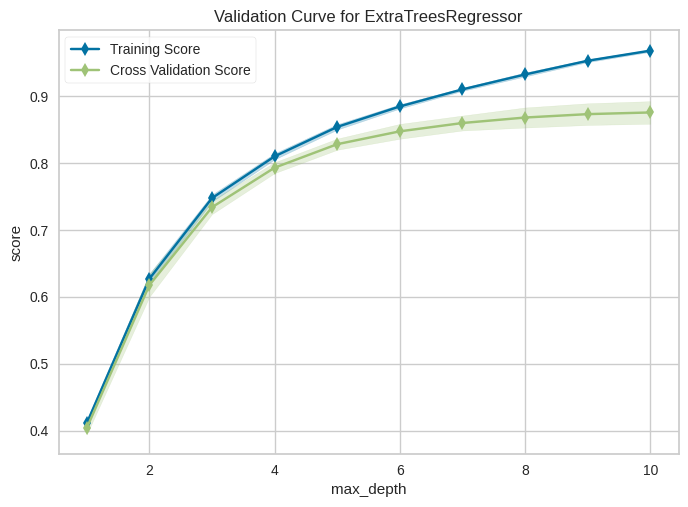

In [21]:
plot_model(best, plot='vc')

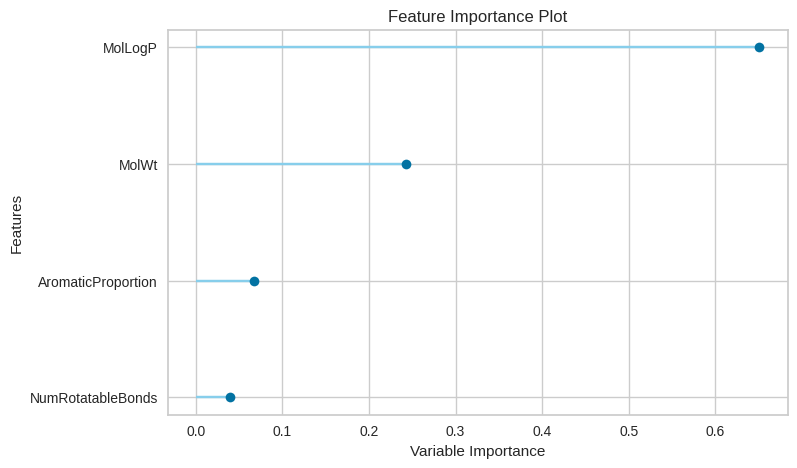

In [22]:
plot_model(best, plot='feature')